<a href="https://colab.research.google.com/github/suumino/pythonanalysis/blob/main/chap04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

uselog = pd.read_csv('use_log.csv')
uselog.isnull().sum()
customer = pd.read_csv('customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

In [2]:
customer_clustering = customer[['mean', 'median', 'max', 'min', 'membership_period']]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [3]:
!pip install KMeans

  Created wheel for KMeans: filename=kmeans-1.0.2-cp37-cp37m-linux_x86_64.whl size=11759 sha256=2dbd3899e4fa6fd4c55e72b613dba2d10af7f6b9a74c890b2a2e7a273187e316
  Stored in directory: /root/.cache/pip/wheels/10/05/77/2735fd2f7a0b4d86cb7a83be2a56807cf706d5d27f742c6482
Successfully built KMeans


In [4]:
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters = 4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering['cluster'] = clusters.labels_
print(customer_clustering['cluster'].unique())
customer_clustering.head()

[3 1 0 2]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


In [5]:
customer_clustering.columns = ['월평균값', '월중앙값', '월최댓값', '월최솟값', '회원기간', 'cluster']
customer_clustering.groupby('cluster').count()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,1334,1334,1334,1334,1334
1,763,763,763,763,763
2,846,846,846,846,846
3,1249,1249,1249,1249,1249


In [6]:
customer_clustering.groupby('cluster').mean()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,5.524239,5.375187,8.745877,2.687406,14.843328
1,3.054713,2.888598,4.756225,1.653997,9.263434
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


In [7]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components = 2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = customer_clustering['cluster']

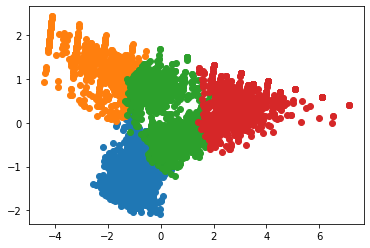

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering['cluster'].unique():
  tmp = pca_df.loc[pca_df['cluster']==i]
  plt.scatter(tmp[0], tmp[1])

In [9]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(['cluster', 'is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,549
2,1,1,763
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


In [10]:
customer_clustering.groupby(['cluster', 'routine_flg'], as_index=False).count()[['cluster', 'routine_flg', 'customer_id']]

,cluster,routine_flg,customer_id
0,0,0,228
1,0,1,1106
2,1,0,497
3,1,1,266
4,2,0,52
5,2,1,794
6,3,0,2
7,3,1,1247


In [11]:
uselog['usedate'] = pd.to_datetime(uselog['usedate'])
uselog['연월'] = uselog['usedate'].dt.strftime('%Y%m')
uselog_months = uselog.groupby(['연월', 'customer_id'], as_index=False).count()
uselog_months.rename(columns = {'log_id':'count'}, inplace=True)
del uselog_months['usedate']
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [12]:
year_months = list(uselog_months['연월'].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
  tmp = uselog_months.loc[uselog_months['연월']==year_months[i]]
  tmp.rename(columns = {'count':'count_pred'}, inplace=True)
  for j in range(1, 7):
    tmp_before = uselog_months.loc[uselog_months['연월']==year_months[i-j]]
    del tmp_before['연월']
    tmp_before.rename(columns={'count':'count_{}'.format(j-1)}, inplace=True)
    tmp = pd.merge(tmp, tmp_before, on='customer_id', how='left')
  predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [13]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


In [14]:
predict_data = pd.merge(predict_data, customer[["customer_id", "start_date"]], on = "customer_id", how="left")
predict_data.head()

,연월,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01
